In [42]:
%matplotlib inline
# # notebook stuff
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# # numpy
import numpy as np
from PIL import Image

# # torch stuff
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, ToPILImage
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchsummary import summary
import torch.nn.functional as F

# our stuff
import importlib
import model.mdnrnn
MDNRNN = importlib.reload(model.mdnrnn).MDNRNN

import dataset
dataset = importlib.reload(dataset)
RNNDataset = dataset.RNNDataset
MultiToTensor = dataset.MultiToTensor
from model.vaelin import VAELin
from constants import *


In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [44]:
dataset = RNNDataset(transform=MultiToTensor())
loader = DataLoader(dataset, batch_size=RNN_BATCH_SIZE, drop_last=True)
vae = VAELin(z_size=LATENT_SIZE, device=device).to(device)
loaded = torch.load(VAE_PATH, map_location=device)
vae.load_state_dict(loaded['model_state_dict'])

rnn = MDNRNN(model_reward=True)
rnn.load_state_dict(torch.load(RNN_PATH, map_location=device)['model_state_dict'])

In [45]:
batch_size = RNN_BATCH_SIZE
def to_latent(batch_frames, vae):
    frames = batch_frames.reshape((RNN_BATCH_SIZE, RNN_SEQ_LEN, 3, HEIGHT, WIDTH))
    latent_seq = vae(frames)[3]
    latent_seqs = latent_seq.reshape((RNN_BATCH_SIZE, RNN_SEQ_LEN, LATENT_SIZE))
    return latent_seqs

In [5]:
model = MDNRNN().to(device)

In [6]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
epochs = 100

In [8]:
#%%
for ep in range(epochs):
    with tqdm_notebook(total=len(loader)) as bar:
        for batch_idx, batch in enumerate(loader):
            optimizer.zero_grad()
            frame_seqs = batch['frame_seq'].to(device).float() # (BATCHSIZE, SEQ_LEN, 3, 64, 64)
            action_seqs = batch['action_seq'].to(device).float().unsqueeze(2) # (BATCHSIZE, SEQ_LEN)
            latent_seqs = to_latent(frame_seqs, vae) # (BATCHSIZE, SEQ_LEN, LATENT_SIZE)

            curr_latent = latent_seqs[:,:-1]
            curr_actions = action_seqs[:,:-1]
            next_latent = latent_seqs[:,1:]
            mus, logsigmas, logpis, rnn_out, _ = model(curr_latent, curr_actions, prev_rnn_hidden=None)

            loss = model.loss(next_latent, mus, logsigmas, logpis)
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            optimizer.step()
            
            bar.update(1)
            bar.set_postfix(ep=ep, avg_loss=sum(losses[-(batch_idx+1):])/(batch_idx+1))

### Training Loss

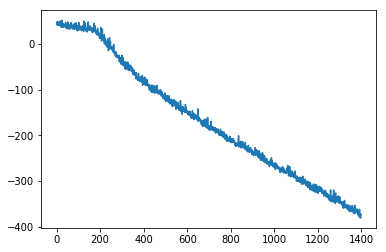

In [9]:
np_losses = np.array(losses)
plt.plot(np_losses)

In [10]:
def sample_gmm(mu, logsigma, logpi):
    choice = torch.distributions.categorical.Categorical(F.softmax(logpi, dim=0)).sample()
    dist = torch.distributions.normal.Normal(mu[choice], logsigma[choice].exp())
    return dist.sample()

### Difference from truth

Given a rollout, see the difference between the actual frame (encoded then decoded) and the predicted state (decoded from predicted latent)

In [47]:
model = rnn

In [50]:
rnn

MDNRNN(
  (rnn): LSTM(33, 256, num_layers=2)
  (gmm): GMM(
    (net): Linear(in_features=256, out_features=326, bias=True)
  )
)

In [49]:
for batch_idx, batch in enumerate(loader):
    break
    
frame_seqs = batch['frame_seq'].to(device).float() # (BATCHSIZE, SEQ_LEN, 3, 64, 64)
action_seqs = batch['action_seq'].to(device).float() # (BATCHSIZE, SEQ_LEN, 3, 64, 64)
reward_seqs = batch['reward_seq'].to(device).float()[:, :-1]
action_seq = action_seqs[0,:-1].unsqueeze(1).unsqueeze(0)

fwd = vae(frame_seqs[0])
all_latent_seq = fwd[3].unsqueeze(0)

next_latent_seq = all_latent_seq[:,1:]
next_decoded_seq = vae.decoder(next_latent_seq.unsqueeze(0))

latent_seq = all_latent_seq[:,:-1]
mus, logsigmas, logpis, rnn_out, _, predicted_rewards = model(latent_seq, action_seq, prev_rnn_hidden=None)
mus, logsigmas, logpis = mus.squeeze(), logsigmas.squeeze(), logpis.squeeze()
pred_next_latent_seq = torch.stack([sample_gmm(mus[i], logsigmas[i], logpis[i]) for i in range(len(logsigmas))])
pred_next_decoded_seq = vae.decoder(pred_next_latent_seq.unsqueeze(0))


/home/ubuntu/598rl/project/agou2_dusad2/code/model/mdnrnn.py:88: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  rnn_out, rnn_hidden = self.rnn(inputs, prev_rnn_hidden) # hidden_state is zero


RuntimeError: param_from.type() == param_to.type() ASSERT FAILED at /opt/conda/conda-bld/pytorch_1533672544752/work/aten/src/ATen/native/cudnn/RNN.cpp:491, please report a bug to PyTorch. parameter types mismatch

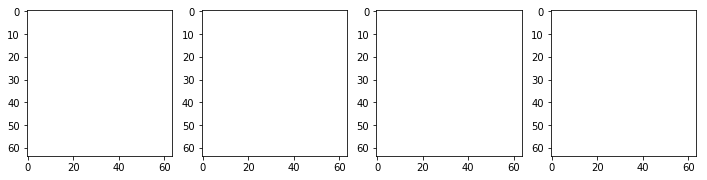

In [31]:
fig = plt.figure(figsize=(12,5))
ims = []
ax1 = plt.subplot(1,4,1)
ax2 = plt.subplot(1,4,2)
ax3 = plt.subplot(1,4,3)
ax4 = plt.subplot(1,4,4)
for i in range(RNN_SEQ_LEN-1):
    frame = frame_seqs[0,i].detach().cpu().numpy().transpose((1,2,0))
    next_decoded = next_decoded_seq[i].detach().cpu().numpy().transpose((1,2,0))
    pred_next_decoded = pred_next_decoded_seq[i].detach().cpu().numpy().transpose((1,2,0))
    im1 = ax1.imshow(np.abs(frame), animated=True)
    im2 = ax2.imshow(np.abs(next_decoded), animated=True)
    im3 = ax3.imshow(np.abs(pred_next_decoded-next_decoded), animated=True)
    im4 = ax4.imshow(np.abs(pred_next_decoded), animated=True)
    ims.append([im1, im2, im3, im4])
anim = animation.ArtistAnimation(fig, ims, interval=20, blit=True)

In [37]:
vid = anim.to_html5_video()

In [38]:
HTML(vid)

### Dream Sequence

From a starting latent, use MDNRNN to predict next latent space with random action

In [18]:
for batch_idx, batch in enumerate(loader):
    break
    
frame_seqs = batch['frame_seq'].to(device).float() # (BATCHSIZE, SEQ_LEN, 3, 64, 64)
latent_seqs = to_latent(frame_seqs, vae) # (BATCHSIZE, SEQ_LEN, LATENT_SIZE)

In [19]:
curr_latent = latent_seqs[0,0].unsqueeze(0).unsqueeze(0)

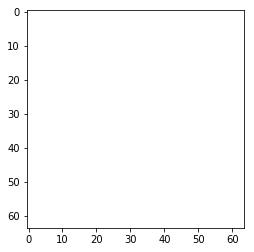

In [27]:
fig = plt.figure()
ims = []

prev_rnn_hidden = None

for i in tqdm_notebook(range(1000)):
    mus, logsigmas, logpis, rnn_out, rnn_hidden = model(curr_latent, torch.randint(0,3,(1,1,1)).to(device) , prev_rnn_hidden)
    prev_rnn_hidden = (torch.tensor(rnn_hidden[0]).detach(), torch.tensor(rnn_hidden[1]).detach())
    
    mu, logsigma, logpi = mus.squeeze(), logsigmas.squeeze(), logpis.squeeze()
    next_latent = sample_gmm(mu, logsigma, logpi)
    
    next_decoded = vae.decoder(next_latent).squeeze().detach().cpu().numpy().transpose((1,2,0))
    im = plt.imshow(next_decoded, animated=True)
    ims.append([im])
    
    curr_latent = next_latent.unsqueeze(0).unsqueeze(0)
anim = animation.ArtistAnimation(fig, ims, interval=20, blit=True)

In [28]:
vid = anim.to_html5_video()

In [29]:
HTML(vid)